## Modeling scRNA-seq using sequence features and a custom kNN graph

In this tutorial we demonstrate the applicability of mubind in a case where an arbitrarily complex graph is provided.
The dataset is mouse pancreatic endocrinogenesis multiome [Klein et al 2023]


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import pandas as pd
import numpy as np
import os
import seaborn
import itertools
import glob

import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [4]:
# these are motifs used during training (pre-weights)
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [5]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [6]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [7]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
# mb.models.Mubind
import torch
import torch
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle


# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [8]:
# device = 'cpu'
print('here...')
import scanpy as sc
print('here...')

here...
here...


In [9]:
# pybiomart is requred
annot = sc.queries.biomart_annotations(
    "mmusculus",
    ["ensembl_gene_id", "start_position", "end_position", "chromosome_name"],
).set_index("ensembl_gene_id")
# rna.var[annot.columns] = annot

In [10]:
tss_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'mm10', 'genome', 'TSS.in')
tss = pd.read_csv(tss_path, sep='\t', header=None)
tss.columns = ['chrom', 'pos', 'strand', 'symbol']
tss = tss.set_index('symbol')
tss = tss[~tss.index.duplicated(keep='first')]

In [11]:
# load the pancreas multiome dataset
rna = sc.read_h5ad('noack_et_al_velocity_graph.h5ad')
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')

In [12]:
rna.var[tss.columns] = tss

In [13]:
rna = rna[:,~pd.isnull(rna.var['pos'])].copy()

In [14]:
rna.var['tss_start'] = rna.var['pos'].astype(int)
rna = rna[:,~pd.isnull(rna.var['tss_start'])]
bp = 100
tss_start = rna.var['tss_start'].astype(int)
rna.var['tss_start'] = np.where(rna.var['strand'] == '+', tss_start - bp, tss_start)
rna.var['tss_end'] = np.where(rna.var['strand'] == '+', tss_start, tss_start + bp)

rna.var['chromosome_name'] = rna.var['chrom']
rna.var['k'] = rna.var['chromosome_name'].astype(str) + ':' + rna.var['tss_start'].astype(str) + '-' + rna.var['tss_end'].astype(str)

In [15]:
rna.var['k'] 

index
Xkr4           chr1:3671498-3671598
Rgs20          chr1:5018734-5018834
Slco5a1      chr1:12991135-12991235
Jph1         chr1:17097889-17097989
Mcm3         chr1:20820213-20820313
                     ...           
Sh3kbp1    chrX:159708501-159708601
Rai2       chrX:161717453-161717553
Ap1s2      chrX:163908917-163909017
Ddx3y          chrY:1286613-1286713
Eif2s3y        chrY:1010512-1010612
Name: k, Length: 1948, dtype: object

In [16]:
# rna.shape, atac.shape
# atac_path = '../../../annotations/scatac/noack_et_al_velocity_graph.h5ad'
# os.path.exists(atac_path)
# ad = sc.read_h5ad(atac_path)

In [17]:
ad = rna

In [18]:
ad.var_names

Index(['Xkr4', 'Rgs20', 'Slco5a1', 'Jph1', 'Mcm3', 'Ogfrl1', 'Prim2', 'Bag2',
       'Bend6', 'Aff3',
       ...
       'Kif4', 'Tmem35a', 'Pak3', 'Alas2', 'Smc1a', 'Sh3kbp1', 'Rai2', 'Ap1s2',
       'Ddx3y', 'Eif2s3y'],
      dtype='object', name='index', length=1948)

In [19]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
sc.pp.neighbors(rna)


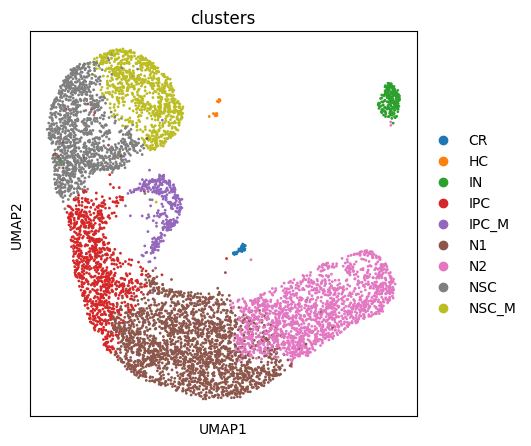

In [20]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='clusters')

#ATAC
# sc.pl.umap(atac, color='celltype')

In [21]:
rna

AnnData object with n_obs × n_vars = 7469 × 1948
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k'
    uns: 'clusters_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_settings'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau

In [22]:
# scv.pl.velocity_embedding_stream(rna, color='celltype')

(array([ 41.,  50.,  34.,  39.,  49.,  47.,  49.,  54.,  45.,  46.,  50.,
         46.,  62.,  52.,  46.,  50.,  49.,  48.,  45.,  62.,  53.,  56.,
         54.,  51.,  58.,  41.,  55.,  45.,  60.,  47.,  38.,  47.,  86.,
         91., 202.]),
 array([0.00060249, 0.01487099, 0.02913949, 0.04340799, 0.05767649,
        0.07194499, 0.08621349, 0.10048199, 0.11475049, 0.12901899,
        0.14328749, 0.15755599, 0.17182449, 0.18609299, 0.20036149,
        0.21462999, 0.22889849, 0.243167  , 0.2574355 , 0.271704  ,
        0.2859725 , 0.300241  , 0.3145095 , 0.328778  , 0.3430465 ,
        0.357315  , 0.3715835 , 0.385852  , 0.4001205 , 0.414389  ,
        0.4286575 , 0.442926  , 0.4571945 , 0.471463  , 0.4857315 ,
        0.5       ]),
 <BarContainer object of 35 artists>)

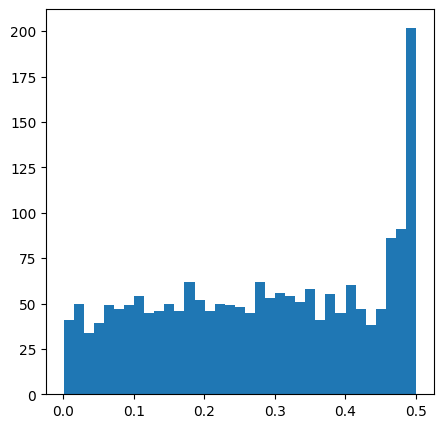

In [23]:
acc = (rna.X != 0).sum(axis=0) / rna.shape[0]
acc_score = abs(.5 - acc)
rna.var['acc_score'] = acc_score.A.T
rna.var['acc_score_rank'] = rna.var['acc_score'].rank(ascending=False)
plt.hist(rna.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [24]:
# n_sample_cells = 750
# n_sample_peaks = 1500

In [25]:
n_cell_types = len(set(rna.obs['clusters']))

In [26]:
n_cell_types

9

In [27]:
rna.shape

(7469, 1948)

In [28]:
rna.obs['clusters'].value_counts()

clusters
N1       2192
N2       1614
NSC      1233
IPC       979
NSC_M     853
IPC_M     337
IN        198
CR         43
HC         20
Name: count, dtype: int64

In [29]:
rna.shape

(7469, 1948)

In [87]:
 # int(n_sample_cells * 1.5)
n_select = 50
n_sample_cells = n_select
n_sample_peaks = rna.shape[1]
# n_select =  int(n_sample_cells / n_cell_types) # bug if > 20
obs_sample = rna.obs.groupby('clusters').sample(n_select, random_state=n_sample_cells, replace=True).index.drop_duplicates()
var_sample = pd.Series(rna.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = rna[rna.obs_names.isin(obs_sample),rna.var_names.isin(var_sample)].copy()
ad.shape

(386, 1948)

In [88]:
ad.obs['clusters'].value_counts()

clusters
N1       50
NSC      50
IPC      49
N2       49
NSC_M    48
IN       47
IPC_M    47
CR       28
HC       18
Name: count, dtype: int64

In [89]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [90]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(386, 386)

In [91]:
# pip install scvelo

In [92]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

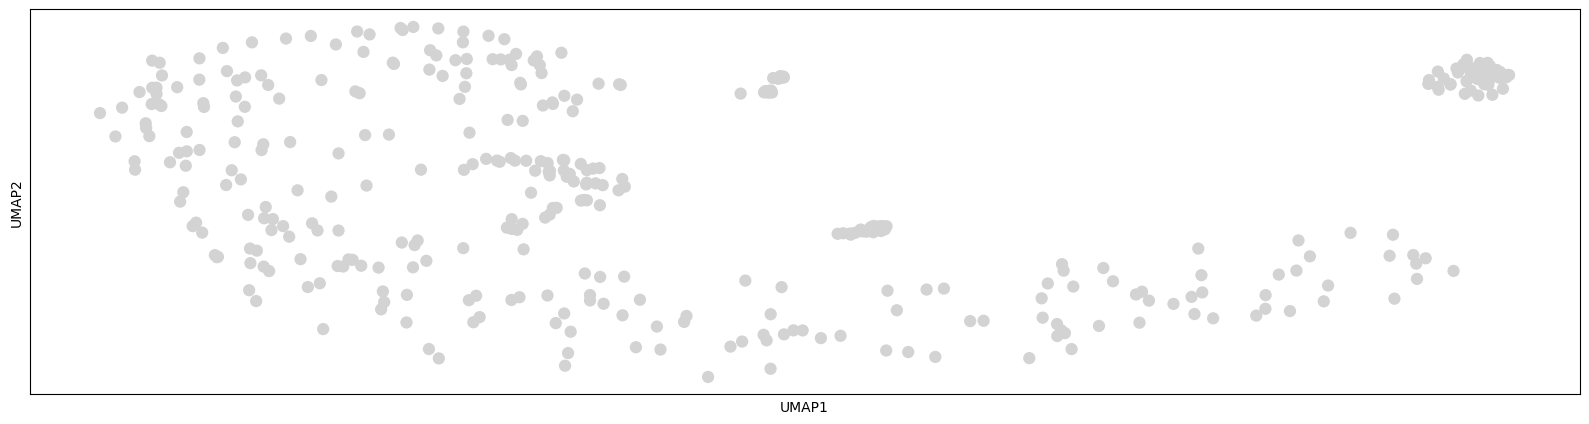

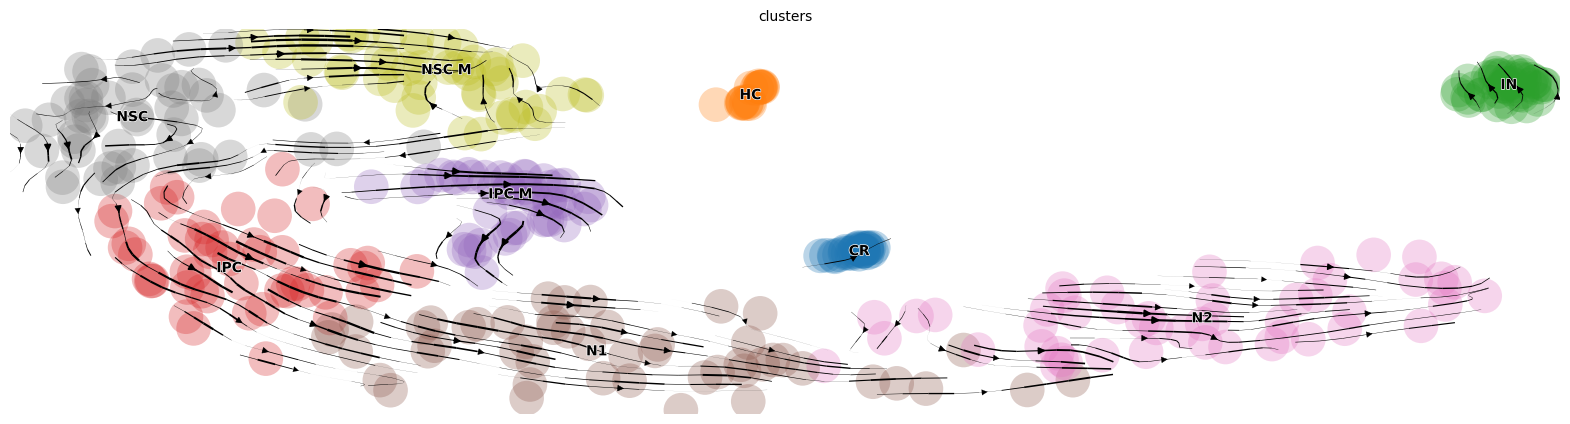

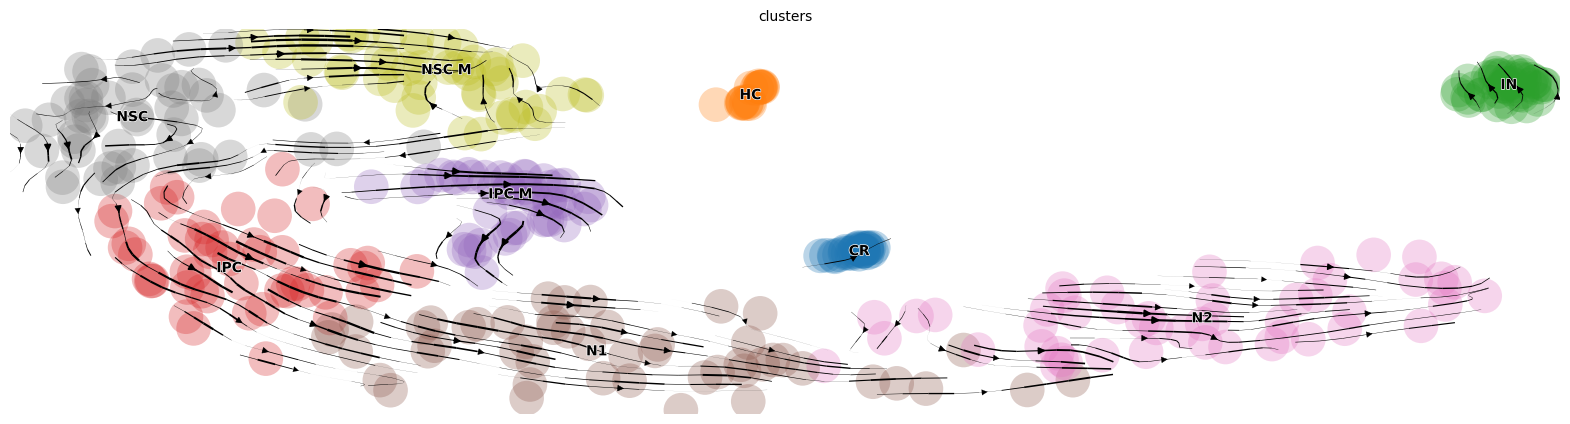

In [93]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [94]:
# ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
# ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
# ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

# print('features by chromosome')
# extend = 50
# ad.var['chr'].value_counts()

In [95]:
# ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
# ad.var['summit.start'] = ad.var['summit'] - extend
# ad.var['summit.end'] = ad.var['summit'] + extend
# ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)
ad.var['chr'] = 'chr' + ad.var['Chromosome'].astype(str)
ad.var['summit.start'] = ad.var['tss_start'].astype(str)
ad.var['summit.end'] = ad.var['tss_end'].astype(str)
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [96]:
ad.shape

(386, 1948)

In [97]:
!ls /home/ilibarra/miniconda3/envs/mubind/bin/bedtools

617.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


/home/ilibarra/miniconda3/envs/mubind/bin/bedtools


In [98]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/miniconda3/envs/mubind/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpknbjbafe
genome mm10 True
annotations/mm10/genome/mm10.fa
True annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/miniconda3/envs/mubind/bin/bedtools', 'getfasta', '-fi', 'annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmpknbjbafe', '-fo', '/tmp/tmpee5ajmbg']
/home/ilibarra/miniconda3/envs/mubind/bin/bedtools getfasta -fi annotations/mm10/genome/mm10.fa -bed /tmp/tmpknbjbafe -fo /tmp/tmpee5ajmbg


1948

In [99]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [100]:
counts.shape

(1948, 386)

In [101]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [102]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [103]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(1948, 387)

In [104]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(1948, 387)

In [105]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [106]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [107]:
# next_data.index

In [108]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [109]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [110]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(1944, 386)

In [111]:
ad.shape, df.shape

((386, 1948), (1944, 386))

In [112]:
ad = ad[:,~zero_counts].copy()


In [113]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(750384, 3)
386
batch
0      1944
137    1944
127    1944
128    1944
129    1944
       ... 
69     1944
70     1944
71     1944
72     1944
199    1944
Name: count, Length: 200, dtype: int64


,0,1,batch
seq,,,
CCATTGGCCGCCGAGTGTGGGAACGGCCGCGGCGCCCGGACCCCAGGCGCCGGGCCGCTGCCCGCGCCTATATAGGGCTGGCGTGCTGGGGTCCAGGTCG,1.0,2.677325,0
GGAGTCCTAGGACTCTAGGATAGAAAGCGAATCTCAGAACAACCGTTCTGAGGGTTAGCTGCATAAAGGACACTGGCCTGAGCCTTGACCTGGTGATCTG,1.0,0.000000,0
TTGCACGCCTTTAACTGATCCGCGGCGCTGAAGGCGGAGAGACCAGAAGAGGAGTGGCCACAAAGATTGCAATTCTGACATCTTATTGGACCTTTAGGTC,1.0,0.000000,0
GCCAATCTGCTTGAGCTTCTGCGTGATAATTATTCATGGGCTCCTGCCTCTTGCTCTTTCTCTAGCACGGTCCCACTCTGCAGACTCAGTGCCTTACTCA,1.0,0.000000,0
CCACGGCAGCCTGCTGGAAAGAGACAAGTTAGTCATTCAAATGATTGGCTTTTTGCCCGCTTCTTCTCTAAATAAGAAGGCAGCAGCTTCTGCTGAGGTG,1.0,3.574537,0


### Simple motif enrichment

In [114]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [115]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [116]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [117]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [118]:
reduced_groups = pwms

In [119]:
df

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,384,385
seq,,,,,,,,,,,,,,,,,,,,,
CCATTGGCCGCCGAGTGTGGGAACGGCCGCGGCGCCCGGACCCCAGGCGCCGGGCCGCTGCCCGCGCCTATATAGGGCTGGCGTGCTGGGGTCCAGGTCG,2.677325,0.689492,1.408823,4.585621,1.548412,1.080756,0.000000,1.497989,0.000000,0.000000,...,3.178005,3.123889,2.895197,1.272064,0.000000,0.000000,3.670112,1.482203,2.424195,0.756481
GGAGTCCTAGGACTCTAGGATAGAAAGCGAATCTCAGAACAACCGTTCTGAGGGTTAGCTGCATAAAGGACACTGGCCTGAGCCTTGACCTGGTGATCTG,0.000000,3.630455,2.666876,1.053133,1.329194,3.529222,3.174899,2.208597,0.485007,3.354277,...,2.858063,0.000000,2.184515,1.579456,4.179218,3.705815,0.000000,0.993740,2.753946,4.012352
TTGCACGCCTTTAACTGATCCGCGGCGCTGAAGGCGGAGAGACCAGAAGAGGAGTGGCCACAAAGATTGCAATTCTGACATCTTATTGGACCTTTAGGTC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.107097,2.410796,2.819751,3.375890,3.194057,2.700630,3.168492,3.140574,3.001507,3.006821
GCCAATCTGCTTGAGCTTCTGCGTGATAATTATTCATGGGCTCCTGCCTCTTGCTCTTTCTCTAGCACGGTCCCACTCTGCAGACTCAGTGCCTTACTCA,0.000000,1.093735,0.708223,0.000000,0.000000,1.587972,0.737948,0.000000,0.000000,3.434860,...,0.000000,0.000000,0.839146,0.000000,3.359412,3.211243,0.000000,0.000000,0.000000,3.337134
CCACGGCAGCCTGCTGGAAAGAGACAAGTTAGTCATTCAAATGATTGGCTTTTTGCCCGCTTCTTCTCTAAATAAGAAGGCAGCAGCTTCTGCTGAGGTG,3.574537,0.689492,1.408823,1.334982,2.129183,0.000000,1.452764,0.768979,0.485007,0.000000,...,2.220710,4.051960,1.598007,1.272064,0.000000,0.000000,1.535460,1.658855,2.122530,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGCTTCCCAGGCCACCCAAAGTGGCTAGGAGGTGGGGAAGACAAACCCCGCCCAAGCCCTAAGAGGGGAGAACTGGCTCTGAGAATTTCTGGTCAACCCT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ACTGGGCACCACCACCCTGGTGTCCTTTGGAAACCACTGCCTTCCCTTGGCTGCTGCTTTATAACCTCCTCTATTGCAACATAATTCATCACTTTGCTTT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CTTACTCTGGCTGTATCTTCTCATTGTTGCTTTTGGACGGTTGCCCTCTTTCCCAAAGGTGTCTGTCTGCACATTTCGTAGAGCGAGTGTTCCGATACTC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [120]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)


In [121]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [122]:
len(pwms)

286

In [123]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [124]:
rna_sample.shape, ad.shape

((386, 1948), (386, 1944))

In [125]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [126]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(386, 386)
setting up log dynamic
no err


In [127]:
model.graph_module.conn_sparse.shape

torch.Size([386, 386])

setting up log dynamic
True
12
order None
0 out of 288...
break


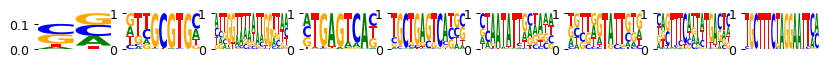

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels 0-69, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 10 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.93it/s]


Current time: 2024-07-05 00:42:40.339829
	Loss: 227.108 , R2: 0.522
	Training time (model/function): (5.193s / 5.193s)
		per epoch (model/function): (0.577s/ 0.577s)
		per 1k samples: 0.297s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986158036043563, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels 70-139, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.81it/s]


Current time: 2024-07-05 00:42:51.780208
	Loss: 172.192 , R2: 0.522
	Training time (model/function): (16.274s / 11.081s)
		per epoch (model/function): (0.857s/ 0.583s)
		per 1k samples: 0.300s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986158036043563, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.02it/s]


Current time: 2024-07-05 00:43:02.030920
	Loss: 151.921 , R2: 0.522
	Training time (model/function): (26.181s / 9.907s)
		per epoch (model/function): (1.378s/ 0.521s)
		per 1k samples: 0.268s
best loss 151.921
last five r2 values, by sequential filter optimization: ['0.522']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986158036043563, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels 140-209, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.95it/s]


Current time: 2024-07-05 00:43:13.001817
	Loss: 150.814 , R2: 0.522
	Training time (model/function): (36.474s / 10.293s)
		per epoch (model/function): (1.920s/ 0.542s)
		per 1k samples: 0.279s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986158036043563, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06it/s]


Current time: 2024-07-05 00:43:23.037206
	Loss: 145.589 , R2: 0.522
	Training time (model/function): (46.180s / 9.706s)
		per epoch (model/function): (2.431s/ 0.511s)
		per 1k samples: 0.263s
best loss 145.589
last five r2 values, by sequential filter optimization: ['0.522', '0.522']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986158036043563, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels 210-279, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


Current time: 2024-07-05 00:43:34.148449
	Loss: 148.943 , R2: 0.522
	Training time (model/function): (56.479s / 10.299s)
		per epoch (model/function): (2.973s/ 0.542s)
		per 1k samples: 0.279s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986158036043563, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10it/s]


Current time: 2024-07-05 00:43:44.035048
	Loss: 145.034 , R2: 0.522
	Training time (model/function): (66.017s / 9.538s)
		per epoch (model/function): (3.475s/ 0.502s)
		per 1k samples: 0.258s
best loss 145.034
last five r2 values, by sequential filter optimization: ['0.522', '0.522', '0.522']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986158036043563, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels 280-349, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]


Current time: 2024-07-05 00:43:54.893848
	Loss: 148.777 , R2: 0.522
	Training time (model/function): (76.240s / 10.223s)
		per epoch (model/function): (4.013s/ 0.538s)
		per 1k samples: 0.277s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986158036043563, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14it/s]


Current time: 2024-07-05 00:44:04.567987
	Loss: 144.985 , R2: 0.522
	Training time (model/function): (85.587s / 9.347s)
		per epoch (model/function): (4.505s/ 0.492s)
		per 1k samples: 0.253s
best loss 144.984
last five r2 values, by sequential filter optimization: ['0.522', '0.522', '0.522', '0.522']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9986158036043563, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 85.58695578575134s
Time per epoch (total): 0.015 s
True
12
order None
0 out of 288...


In [135]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 10
n_epochs_kernel = 20
log_each=75
n_unfreeze_kernels=70

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None) # .cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model.graph_module.use_hadamard = True
    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                # skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

In [ ]:
lib_sizes = train.dataset.rounds.sum(axis=0).flatten()

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
for use_logdynamic in [False, True]:
    p = 'noack_2022_use_logdynamic_%i_obs%i.pth' % (use_logdynamic, ad.shape[0])
    print(p)
    torch.save(model_by_logdynamic[use_logdynamic], p)

noack_2022_use_logdynamic_0_obs86.pth
noack_2022_use_logdynamic_1_obs86.pth


In [ ]:
ad.shape

(86, 1916)

In [ ]:
ad.write('noack_2022_sample_train_obs%i.h5ad' % ad.shape[0])

In [ ]:
import pickle
pickle.dump(train, open('train_dataloader_obs%i.pkl' % ad.shape[0], 'wb'))